In [1]:
# Execute this for split-screen desktop.

import os
from IPython.display import display, HTML
from sidecar import Sidecar

try:
    JUPYTERHUB_USER = os.environ['JUPYTERHUB_USER']
except KeyError:
    JUPYTERHUB_USER = None
url_prefix = f"/user/{JUPYTERHUB_USER}" if JUPYTERHUB_USER is not None else ''
remote_desktop_url = f"{url_prefix}/desktop"
sc = Sidecar(title='Desktop')
with sc:
    # The inserted custom HTML and CSS snippets are to make the tab resizable
    display(HTML(f"""
        <style>
        body.p-mod-override-cursor div.iframe-widget {{
            position: relative;
            pointer-events: none;

        }}

        body.p-mod-override-cursor div.iframe-widget:before {{
            content: '';
            position: absolute;
            top: 0;
            left: 0;
            right: 0;
            bottom: 0;
            background: transparent;
        }}
        </style>
        <div class="iframe-widget" style="width: calc(100% + 10px);height:100%;">
            <iframe src="{remote_desktop_url}" width="100%" height="100%"></iframe>
        </div>
    """))

# Assignment 2 - Coordinates & Transforms

## Build your Turtlebot

The task of this assignment is to build the TortugaBot through Visualization Markers. Lets first set up the environment.

Open Rviz. ([references](https://docs.ros.org/en/jazzy/Tutorials/Intermediate/RViz/RViz-User-Guide/RViz-User-Guide.html))
```bash
rviz2
```
* Set Global options > Fixed frame to `/world`. 
* Then add TF.

Start the turtlesim demo from [the TF2 tutorials](https://docs.ros.org/en/jazzy/Tutorials/Intermediate/Tf2/Introduction-To-Tf2.html) in one terminal here:
```bash
ros2 launch turtle_tf2_py turtle_tf2_demo.launch.py
```
and in another terminal run
```bash
ros2 run turtlesim turtle_teleop_key
```
Move turtle with arrow keys in the terminal.

Execute the below python code blocks to publish arrow on the turtle1 frame

https://wiki.ros.org/rviz/DisplayTypes/Marker


## Example: How to publish markers

In [2]:
import rclpy
from rclpy.node import Node
from visualization_msgs.msg import Marker

In [3]:
class Balloon(Node):
    def __init__(self):
        # Initialize the ROS Node Publisher
        super().__init__('balloon_marker')
        self.publisher_ = self.create_publisher(Marker, 'balloon', 10)
        
        # Setting the timer creates a scheduled callback for rclpy.spin
        timer_period = 0.5  # in seconds
        self.timer = self.create_timer(timer_period, self.publish_marker)

        # Design the marker
        self.marker = Marker()
        self.marker.header.frame_id = '/turtle1'
        self.marker.header.stamp = self.get_clock().now().to_msg()
        self.marker.type = self.marker.SPHERE
        self.marker.id = 0
        self.marker.action = self.marker.ADD
        self.marker.scale.x = 0.4
        self.marker.scale.y = 0.4
        self.marker.scale.z = 0.4
        self.marker.color.r = 1.0
        self.marker.color.g = 0.0
        self.marker.color.b = 0.0
        self.marker.color.a = 1.0
        self.marker.pose.position.x = 0.0
        self.marker.pose.position.y = 0.0
        self.marker.pose.position.z = 0.5
        self.get_logger().info("Publishing the " + self.publisher_.topic + " topic. Use RViz to visualize.")

    
    def publish_marker(self):
        self.marker.header.stamp = self.get_clock().now().to_msg()
        self.publisher_.publish(self.marker)

In [4]:
# Initialize rclpy ROS communication
rclpy.init()
# Instantiate ROS node
balloon = Balloon()

[INFO] [1746390115.879887917] [balloon_marker]: Publishing the balloon topic. Use RViz to visualize.


In Rviz `Add` > `By topic` > `/balloon` > Marker

In [5]:
balloon.publish_marker()

There should now be a red baloon above `turtle1`. To publish continually, spin the node.

In [6]:
rclpy.spin(balloon)

KeyboardInterrupt: 

Clean up afterwards

In [7]:
balloon.destroy_node()  

NameError: name 'balloon' is not defined

In [17]:
rclpy.shutdown()

## Example: How to use rotation

In [18]:
import sys
!{sys.executable} -m pip install transforms3d

In [19]:
from tf_transformations import euler_matrix, quaternion_from_matrix, rotation_from_matrix, euler_from_matrix

In [20]:
# Standard rotation
r = euler_matrix(0,0,0)

In [21]:
# All rotations are represented as matrices underneath.
r

array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]])

In [22]:
# Quaternion
quaternion_from_matrix(r)

(np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(1.0))

In [23]:
# Angle Rotations
angle, _, _ = rotation_from_matrix(r)
angle

0.0

In [24]:
# Euler Angle
euler_from_matrix(r)

(0.0, -0.0, 0.0)

In [25]:
import numpy as np

In [26]:
r = euler_matrix(np.pi,0,0)

In [27]:
q = quaternion_from_matrix(r)

In [28]:
ax, ay, az, w = q

In [29]:
marker = Marker()
marker.header.frame_id = '/world'
marker.type = marker.ARROW
marker.id = 99
marker.action = marker.ADD
marker.scale.x = 0.5
marker.scale.y = 0.1
marker.scale.z = 0.1
marker.color.r = 0.0
marker.color.g = 1.0
marker.color.b = 0.0
marker.color.a = 1.0
marker.pose.orientation.x = ax
marker.pose.orientation.y = ay
marker.pose.orientation.z = az
marker.pose.orientation.w = w

In [30]:
import rclpy
from rclpy.node import Node
from visualization_msgs.msg import Marker

rclpy.init()
marker_pub = Node("example_rotation_publisher")
marker_pub.publisher_ = marker_pub.create_publisher(Marker, 'example_rotations', 10)
marker.header.stamp = marker_pub.get_clock().now().to_msg()
marker_pub.publisher_.publish(marker)

In [33]:
import time
from copy import copy

num_arrows = 20
bow_split = np.pi * 2 / num_arrows

for i in range(0, num_arrows):
    r = euler_matrix(0, bow_split * i, 0)
    ax, ay, az, w = quaternion_from_matrix(r)
    marker.pose.orientation.x = ax
    marker.pose.orientation.y = ay
    marker.pose.orientation.z = az
    marker.pose.orientation.w = w
    marker.id = 100 + i
    marker_pub.publisher_.publish(marker)
    time.sleep(0.1)

# Tasks

## Task 1

After you have configured Rvizweb, save the settings on your local machine. This will save you time the next time you configure Rvizweb. 
Additionally, paste your source code here:
    
```bash
## Your config goes here:
# TODO
tahaos@tahaos-ROG-Strix-G531GT-G531GT:~/.rviz2$ cat assignment2_2.rviz 
Panels:
  - Class: rviz_common/Displays
    Help Height: 78
    Name: Displays
    Property Tree Widget:
      Expanded:
        - /Global Options1
        - /Status1
        - /MarkerArray1
      Splitter Ratio: 0.5
    Tree Height: 526
  - Class: rviz_common/Selection
    Name: Selection
  - Class: rviz_common/Tool Properties
    Expanded:
      - /2D Goal Pose1
      - /Publish Point1
    Name: Tool Properties
    Splitter Ratio: 0.5886790156364441
  - Class: rviz_common/Views
    Expanded:
      - /Current View1
    Name: Views
    Splitter Ratio: 0.5
  - Class: rviz_common/Time
    Experimental: false
    Name: Time
    SyncMode: 0
    SyncSource: ""
Visualization Manager:
  Class: ""
  Displays:
    - Alpha: 0.5
      Cell Size: 1
      Class: rviz_default_plugins/Grid
      Color: 160; 160; 164
      Enabled: true
      Line Style:
        Line Width: 0.029999999329447746
        Value: Lines
      Name: Grid
      Normal Cell Count: 0
      Offset:
        X: 0
        Y: 0
        Z: 0
      Plane: XY
      Plane Cell Count: 10
      Reference Frame: <Fixed Frame>
      Value: true
    - Class: rviz_default_plugins/TF
      Enabled: true
      Filter (blacklist): ""
      Filter (whitelist): ""
      Frame Timeout: 15
      Frames:
        All Enabled: true
        turtle1:
          Value: true
        turtle2:
          Value: true
        world:
          Value: true
      Marker Scale: 1
      Name: TF
      Show Arrows: true
      Show Axes: true
      Show Names: false
      Tree:
        world:
          turtle1:
            {}
          turtle2:
            {}
      Update Interval: 0
      Value: true
    - Class: rviz_default_plugins/Marker
      Enabled: true
      Name: Marker
      Namespaces:
        {}
      Topic:
        Depth: 5
        Durability Policy: Volatile
        Filter size: 10
        History Policy: Keep Last
        Reliability Policy: Reliable
        Value: /balloon
      Value: true
    - Class: rviz_default_plugins/Marker
      Enabled: true
      Name: Marker
      Namespaces:
        {}
      Topic:
        Depth: 5
        Durability Policy: Volatile
        Filter size: 10
        History Policy: Keep Last
        Reliability Policy: Reliable
        Value: /example_rotations
      Value: true
    - Class: rviz_default_plugins/MarkerArray
      Enabled: true
      Name: MarkerArray
      Namespaces:
        "": true
      Topic:
        Depth: 5
        Durability Policy: Volatile
        History Policy: Keep Last
        Reliability Policy: Reliable
        Value: /turtle1
      Value: true
    - Class: rviz_default_plugins/MarkerArray
      Enabled: true
      Name: MarkerArray
      Namespaces:
        "": true
      Topic:
        Depth: 5
        Durability Policy: Volatile
        History Policy: Keep Last
        Reliability Policy: Reliable
        Value: /turtle2
      Value: true
  Enabled: true
  Global Options:
    Background Color: 48; 48; 48
    Fixed Frame: world
    Frame Rate: 30
  Name: root
  Tools:
    - Class: rviz_default_plugins/Interact
      Hide Inactive Objects: true
    - Class: rviz_default_plugins/MoveCamera
    - Class: rviz_default_plugins/Select
    - Class: rviz_default_plugins/FocusCamera
    - Class: rviz_default_plugins/Measure
      Line color: 128; 128; 0
    - Class: rviz_default_plugins/SetInitialPose
      Covariance x: 0.25
      Covariance y: 0.25
      Covariance yaw: 0.06853891909122467
      Topic:
        Depth: 5
        Durability Policy: Volatile
        History Policy: Keep Last
        Reliability Policy: Reliable
        Value: /initialpose
    - Class: rviz_default_plugins/SetGoal
      Topic:
        Depth: 5
        Durability Policy: Volatile
        History Policy: Keep Last
        Reliability Policy: Reliable
        Value: /goal_pose
    - Class: rviz_default_plugins/PublishPoint
      Single click: true
      Topic:
        Depth: 5
        Durability Policy: Volatile
        History Policy: Keep Last
        Reliability Policy: Reliable
        Value: /clicked_point
  Transformation:
    Current:
      Class: rviz_default_plugins/TF
  Value: true
  Views:
    Current:
      Class: rviz_default_plugins/Orbit
      Distance: 6.474525451660156
      Enable Stereo Rendering:
        Stereo Eye Separation: 0.05999999865889549
        Stereo Focal Distance: 1
        Swap Stereo Eyes: false
        Value: false
      Focal Point:
        X: 0.9635942578315735
        Y: 2.1174025535583496
        Z: 0.1694212555885315
      Focal Shape Fixed Size: false
      Focal Shape Size: 0.05000000074505806
      Invert Z Axis: false
      Name: Current View
      Near Clip Distance: 0.009999999776482582
      Pitch: 0.5747961401939392
      Target Frame: <Fixed Frame>
      Value: Orbit (rviz_default_plugins)
      Yaw: 2.616459369659424
    Saved: ~
Window Geometry:
  Displays:
    collapsed: false
  Height: 846
  Hide Left Dock: false
  Hide Right Dock: false
  QMainWindow State: 000000ff00000000fd000000040000000000000156000002a2fc0200000008fb0000001200530065006c0065006300740069006f006e00000001e10000009b0000006000fffffffb0000001e0054006f006f006c002000500072006f007000650072007400690065007302000001ed000001df00000185000000a3fb000000120056006900650077007300200054006f006f02000001df000002110000018500000122fb000000200054006f006f006c002000500072006f0070006500720074006900650073003203000002880000011d000002210000017afb000000100044006900730070006c0061007900730100000042000002a2000000d200fffffffb0000002000730065006c0065006300740069006f006e00200062007500660066006500720200000138000000aa0000023a00000294fb00000014005700690064006500530074006500720065006f02000000e6000000d2000003ee0000030bfb0000000c004b0069006e0065006300740200000186000001060000030c00000261000000010000010f000002a2fc0200000003fb0000001e0054006f006f006c002000500072006f00700065007200740069006500730100000041000000780000000000000000fb0000000a005600690065007700730100000042000002a2000000b200fffffffb0000001200530065006c0065006300740069006f006e010000025a000000b200000000000000000000000200000490000000a9fc0100000001fb0000000a00560069006500770073030000004e00000080000002e100000197000000030000057a00000042fc0100000002fb0000000800540069006d006501000000000000057a000002df00fffffffb0000000800540069006d0065010000000000000450000000000000000000000309000002a200000004000000040000000800000008fc0000000100000002000000010000000a0054006f006f006c00730100000000ffffffff0000000000000000
  Selection:
    collapsed: false
  Time:
    collapsed: false
  Tool Properties:
    collapsed: false
  Views:
    collapsed: false
  Width: 1402
  X: 143
  Y: 43


```

Whenever markers do not load properly, try removing and reinserting the marker display. If this doesn´t work, try refreshing Rvizweb and reinserting your config. 

## Task 2

Below you can see one example of a turtle. It is approx. 40cm long. Use multiple primitive shapes to build the shape of the turtle. Your code should be running without executing the examples above.

The turtle has at least 2 floors and 4 wheels.

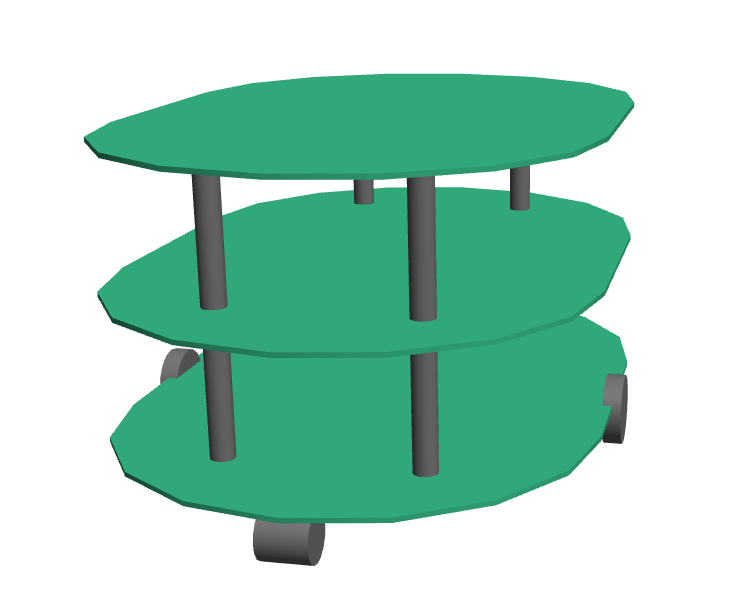

In [11]:
# Your code
import rclpy
from visualization_msgs.msg import Marker, MarkerArray
import geometry_msgs.msg
import std_msgs.msg
from tf_transformations import euler_matrix, quaternion_from_matrix

# rclpy.init('turtle_marker_exercise')
rclpy.init()

In [12]:
from rclpy.node import Node
import numpy as np

class Turtle(Node):
    
    def __init__(self, name, id_seed):
        # Initialize the turtle node including its publisher
        super().__init__(name)
        self.publisher_ = self.create_publisher(MarkerArray, name, 10)

        # Setting the timer creates a scheduled callback for rclpy.spin
        timer_period = 0.3  # in seconds
        self.timer = self.create_timer(timer_period, self.publish_turtle)

        # marker array
        self.markerArr = MarkerArray()

        # Design the turtle marker
        bar_z = 0.15
        # first floor
        self.floorOne= Marker()
        self.floorOne.header.frame_id = f'/{name}'
        self.floorOne.header.stamp = self.get_clock().now().to_msg()
        self.floorOne.type = self.floorOne.CYLINDER
        self.floorOne.id = id_seed + 0
        self.floorOne.action = self.floorOne.ADD
        self.floorOne.scale.x = 0.46
        self.floorOne.scale.y = 0.36
        self.floorOne.scale.z = 0.01
        self.floorOne.color.r = 0.0
        self.floorOne.color.g = 0.6
        self.floorOne.color.b = 0.4
        self.floorOne.color.a = 1.0
        self.floorOne.pose.position.x = 0.0
        self.floorOne.pose.position.y = 0.0
        self.floorOne.pose.position.z = 0.02
        self.markerArr.markers.append(self.floorOne)
        self.get_logger().info("[floor one] Publishing the " + self.publisher_.topic + " topic. Use RViz to visualize.")

        # wheel front
        self.wheelFront = Marker()
        self.wheelFront.header.frame_id = f'/{name}'
        self.wheelFront.header.stamp = self.get_clock().now().to_msg()
        self.wheelFront.type = self.wheelFront.CYLINDER
        self.wheelFront.id = id_seed +1
        self.wheelFront.action = self.wheelFront.ADD
        self.wheelFront.scale.x = 0.05
        self.wheelFront.scale.y = 0.05
        self.wheelFront.scale.z = 0.04
        self.wheelFront.color.r = 0.2
        self.wheelFront.color.g = 0.2
        self.wheelFront.color.b = 0.2
        self.wheelFront.color.a = 1.0
        self.wheelFront.pose.position.x = 0.22
        self.wheelFront.pose.position.y = 0.0
        self.wheelFront.pose.position.z = self.floorOne.pose.position.z - (self.floorOne.scale.z/2) - (self.wheelFront.scale.y/2)
        r = euler_matrix(np.pi/2,0,0)
        q = quaternion_from_matrix(r)
        ax, ay, az, w = q
        self.wheelFront.pose.orientation.x = ax
        self.wheelFront.pose.orientation.y = ay
        self.wheelFront.pose.orientation.z = az
        self.wheelFront.pose.orientation.w = w
        self.markerArr.markers.append(self.wheelFront)
        self.get_logger().info("[wheel front] Publishing the " + self.publisher_.topic + " topic. Use RViz to visualize.")

        # wheel back
        self.wheelBack = Marker()
        self.wheelBack.header.frame_id = f'/{name}'
        self.wheelBack.header.stamp = self.get_clock().now().to_msg()
        self.wheelBack.type = self.wheelBack.CYLINDER
        self.wheelBack.id = id_seed +2
        self.wheelBack.action = self.wheelBack.ADD
        self.wheelBack.scale.x = 0.05
        self.wheelBack.scale.y = 0.05
        self.wheelBack.scale.z = 0.04
        self.wheelBack.color.r = 0.2
        self.wheelBack.color.g = 0.2
        self.wheelBack.color.b = 0.2
        self.wheelBack.color.a = 1.0
        self.wheelBack.pose.position.x = -0.22
        self.wheelBack.pose.position.y = 0.0
        self.wheelBack.pose.position.z = self.floorOne.pose.position.z - (self.floorOne.scale.z/2) - (self.wheelBack.scale.y/2)
        r = euler_matrix(np.pi/2,0,0)
        q = quaternion_from_matrix(r)
        ax, ay, az, w = q
        self.wheelBack.pose.orientation.x = ax
        self.wheelBack.pose.orientation.y = ay
        self.wheelBack.pose.orientation.z = az
        self.wheelBack.pose.orientation.w = w
        self.markerArr.markers.append(self.wheelBack)
        self.get_logger().info("[wheel back] Publishing the " + self.publisher_.topic + " topic. Use RViz to visualize.")

        # wheel left
        self.wheelLeft = Marker()
        self.wheelLeft.header.frame_id = f'/{name}'
        self.wheelLeft.header.stamp = self.get_clock().now().to_msg()
        self.wheelLeft.type = self.wheelBack.CYLINDER
        self.wheelLeft.id = id_seed +3
        self.wheelLeft.action = self.wheelLeft.ADD
        self.wheelLeft.scale.x = 0.06
        self.wheelLeft.scale.y = 0.06
        self.wheelLeft.scale.z = 0.02
        self.wheelLeft.color.r = 0.2
        self.wheelLeft.color.g = 0.2
        self.wheelLeft.color.b = 0.2
        self.wheelLeft.color.a = 1.0
        self.wheelLeft.pose.position.x = 0.0
        self.wheelLeft.pose.position.y = -((self.floorOne.scale.y/2) + (self.wheelLeft.scale.z/2))
        self.wheelLeft.pose.position.z = 0.0
        r = euler_matrix(np.pi/2,0,0)
        q = quaternion_from_matrix(r)
        ax, ay, az, w = q
        self.wheelLeft.pose.orientation.x = ax
        self.wheelLeft.pose.orientation.y = ay
        self.wheelLeft.pose.orientation.z = az
        self.wheelLeft.pose.orientation.w = w
        self.markerArr.markers.append(self.wheelLeft)
        self.get_logger().info("[wheel left] Publishing the " + self.publisher_.topic + " topic. Use RViz to visualize.")

        # wheel right
        self.wheelRight = Marker()
        self.wheelRight.header.frame_id = f'/{name}'
        self.wheelRight.header.stamp = self.get_clock().now().to_msg()
        self.wheelRight.type = self.wheelBack.CYLINDER
        self.wheelRight.id = id_seed + 4
        self.wheelRight.action = self.wheelRight.ADD
        self.wheelRight.scale.x = 0.06
        self.wheelRight.scale.y = 0.06
        self.wheelRight.scale.z = 0.02
        self.wheelRight.color.r = 0.2
        self.wheelRight.color.g = 0.2
        self.wheelRight.color.b = 0.2
        self.wheelRight.color.a = 1.0
        self.wheelRight.pose.position.x = 0.0
        self.wheelRight.pose.position.y = ((self.floorOne.scale.y/2) + (self.wheelRight.scale.z/2))
        self.wheelRight.pose.position.z = 0.0
        r = euler_matrix(np.pi/2,0,0)
        q = quaternion_from_matrix(r)
        ax, ay, az, w = q
        self.wheelRight.pose.orientation.x = ax
        self.wheelRight.pose.orientation.y = ay
        self.wheelRight.pose.orientation.z = az
        self.wheelRight.pose.orientation.w = w
        self.markerArr.markers.append(self.wheelRight)
        self.get_logger().info("[wheel right] Publishing the " + self.publisher_.topic + " topic. Use RViz to visualize.")


        # bar one floor one
        self.barOneFloorOne = Marker()
        self.barOneFloorOne.header.frame_id = f'/{name}'
        self.barOneFloorOne.header.stamp = self.get_clock().now().to_msg()
        self.barOneFloorOne.type = self.barOneFloorOne.CYLINDER
        self.barOneFloorOne.id = id_seed + 5
        self.barOneFloorOne.action = self.barOneFloorOne.ADD
        self.barOneFloorOne.scale.x = 0.02
        self.barOneFloorOne.scale.y = 0.02
        self.barOneFloorOne.scale.z = bar_z
        self.barOneFloorOne.color.r = 0.2
        self.barOneFloorOne.color.g = 0.2
        self.barOneFloorOne.color.b = 0.2
        self.barOneFloorOne.color.a = 1.0
        self.barOneFloorOne.pose.position.x = 0.1
        self.barOneFloorOne.pose.position.y = 0.1
        self.barOneFloorOne.pose.position.z = self.floorOne.pose.position.z + (self.floorOne.scale.z/2) + (self.barOneFloorOne.scale.z/2)
        self.markerArr.markers.append(self.barOneFloorOne)
        self.get_logger().info("[bar one of floor one] Publishing the " + self.publisher_.topic + " topic. Use RViz to visualize.")

        # bar two floor one
        self.barTwoFloorOne = Marker()
        self.barTwoFloorOne.header.frame_id = f'/{name}'
        self.barTwoFloorOne.header.stamp = self.get_clock().now().to_msg()
        self.barTwoFloorOne.type = self.barTwoFloorOne.CYLINDER
        self.barTwoFloorOne.id = id_seed + 6
        self.barTwoFloorOne.action = self.barTwoFloorOne.ADD
        self.barTwoFloorOne.scale.x = 0.02
        self.barTwoFloorOne.scale.y = 0.02
        self.barTwoFloorOne.scale.z = bar_z
        self.barTwoFloorOne.color.r = 0.2
        self.barTwoFloorOne.color.g = 0.2
        self.barTwoFloorOne.color.b = 0.2
        self.barTwoFloorOne.color.a = 1.0
        self.barTwoFloorOne.pose.position.x = 0.1
        self.barTwoFloorOne.pose.position.y = -0.1
        self.barTwoFloorOne.pose.position.z = self.floorOne.pose.position.z + (self.floorOne.scale.z/2) + (self.barTwoFloorOne.scale.z/2)
        self.markerArr.markers.append(self.barTwoFloorOne)
        self.get_logger().info("[bar two of floor one] Publishing the " + self.publisher_.topic + " topic. Use RViz to visualize.")

        # bar three floor one
        self.barThreeFloorOne = Marker()
        self.barThreeFloorOne.header.frame_id = f'/{name}'
        self.barThreeFloorOne.header.stamp = self.get_clock().now().to_msg()
        self.barThreeFloorOne.type = self.barThreeFloorOne.CYLINDER
        self.barThreeFloorOne.id = id_seed + 7
        self.barThreeFloorOne.action = self.barThreeFloorOne.ADD
        self.barThreeFloorOne.scale.x = 0.02
        self.barThreeFloorOne.scale.y = 0.02
        self.barThreeFloorOne.scale.z = bar_z
        self.barThreeFloorOne.color.r = 0.2
        self.barThreeFloorOne.color.g = 0.2
        self.barThreeFloorOne.color.b = 0.2
        self.barThreeFloorOne.color.a = 1.0
        self.barThreeFloorOne.pose.position.x = -0.1
        self.barThreeFloorOne.pose.position.y = 0.1
        self.barThreeFloorOne.pose.position.z = self.floorOne.pose.position.z + (self.floorOne.scale.z/2) + (self.barThreeFloorOne.scale.z/2)
        self.markerArr.markers.append(self.barThreeFloorOne)
        self.get_logger().info("[bar three of floor one] Publishing the " + self.publisher_.topic + " topic. Use RViz to visualize.")

        # bar four floor one
        self.barFourFloorOne = Marker()
        self.barFourFloorOne.header.frame_id = f'/{name}'
        self.barFourFloorOne.header.stamp = self.get_clock().now().to_msg()
        self.barFourFloorOne.type = self.barFourFloorOne.CYLINDER
        self.barFourFloorOne.id = id_seed + 8
        self.barFourFloorOne.action = self.barFourFloorOne.ADD
        self.barFourFloorOne.scale.x = 0.02
        self.barFourFloorOne.scale.y = 0.02
        self.barFourFloorOne.scale.z = bar_z
        self.barFourFloorOne.color.r = 0.2
        self.barFourFloorOne.color.g = 0.2
        self.barFourFloorOne.color.b = 0.2
        self.barFourFloorOne.color.a = 1.0
        self.barFourFloorOne.pose.position.x = -0.1
        self.barFourFloorOne.pose.position.y = -0.1
        self.barFourFloorOne.pose.position.z = self.floorOne.pose.position.z + (self.floorOne.scale.z/2) + (self.barFourFloorOne.scale.z/2)
        self.markerArr.markers.append(self.barFourFloorOne)
        self.get_logger().info("[bar four of floor one] Publishing the " + self.publisher_.topic + " topic. Use RViz to visualize.")

        # floor two
        self.floorTwo= Marker()
        self.floorTwo.header.frame_id = f'/{name}'
        self.floorTwo.header.stamp = self.get_clock().now().to_msg()
        self.floorTwo.type = self.floorTwo.CYLINDER
        self.floorTwo.id = id_seed + 9
        self.floorTwo.action = self.floorTwo.ADD
        self.floorTwo.scale.x = 0.46
        self.floorTwo.scale.y = 0.36
        self.floorTwo.scale.z = 0.01
        self.floorTwo.color.r = 0.0
        self.floorTwo.color.g = 0.6
        self.floorTwo.color.b = 0.4
        self.floorTwo.color.a = 1.0
        self.floorTwo.pose.position.x = 0.0
        self.floorTwo.pose.position.y = 0.0
        self.floorTwo.pose.position.z = (self.floorTwo.scale.z/2) + (self.barOneFloorOne.scale.z/2) + (self.barTwoFloorOne.pose.position.z)
        self.markerArr.markers.append(self.floorTwo)
        self.get_logger().info("[floor two] Publishing the " + self.publisher_.topic + " topic. Use RViz to visualize.")

        # bar one floor two
        self.barOneFloorTwo = Marker()
        self.barOneFloorTwo.header.frame_id = f'/{name}'
        self.barOneFloorTwo.header.stamp = self.get_clock().now().to_msg()
        self.barOneFloorTwo.type = self.barOneFloorTwo.CYLINDER
        self.barOneFloorTwo.id = id_seed + 10
        self.barOneFloorTwo.action = self.barOneFloorTwo.ADD
        self.barOneFloorTwo.scale.x = 0.02
        self.barOneFloorTwo.scale.y = 0.02
        self.barOneFloorTwo.scale.z = bar_z
        self.barOneFloorTwo.color.r = 0.2
        self.barOneFloorTwo.color.g = 0.2
        self.barOneFloorTwo.color.b = 0.2
        self.barOneFloorTwo.color.a = 1.0
        self.barOneFloorTwo.pose.position.x = 0.1
        self.barOneFloorTwo.pose.position.y = 0.1
        self.barOneFloorTwo.pose.position.z = self.floorTwo.pose.position.z + (self.floorTwo.scale.z/2) + (self.barOneFloorTwo.scale.z/2)
        self.markerArr.markers.append(self.barOneFloorTwo)
        self.get_logger().info("[bar one of floor two] Publishing the " + self.publisher_.topic + " topic. Use RViz to visualize.")

        # bar two floor two
        self.barTwoFloorTwo = Marker()
        self.barTwoFloorTwo.header.frame_id = f'/{name}'
        self.barTwoFloorTwo.header.stamp = self.get_clock().now().to_msg()
        self.barTwoFloorTwo.type = self.barTwoFloorTwo.CYLINDER
        self.barTwoFloorTwo.id = id_seed + 11
        self.barTwoFloorTwo.action = self.barTwoFloorTwo.ADD
        self.barTwoFloorTwo.scale.x = 0.02
        self.barTwoFloorTwo.scale.y = 0.02
        self.barTwoFloorTwo.scale.z = bar_z
        self.barTwoFloorTwo.color.r = 0.2
        self.barTwoFloorTwo.color.g = 0.2
        self.barTwoFloorTwo.color.b = 0.2
        self.barTwoFloorTwo.color.a = 1.0
        self.barTwoFloorTwo.pose.position.x = 0.1
        self.barTwoFloorTwo.pose.position.y = -0.1
        self.barTwoFloorTwo.pose.position.z = self.floorTwo.pose.position.z + (self.floorTwo.scale.z/2) + (self.barTwoFloorTwo.scale.z/2)
        self.markerArr.markers.append(self.barTwoFloorTwo)
        self.get_logger().info("[bar two of floor two] Publishing the " + self.publisher_.topic + " topic. Use RViz to visualize.")
        
        # bar three floor two
        self.barThreeFloorTwo = Marker()
        self.barThreeFloorTwo.header.frame_id = f'/{name}'
        self.barThreeFloorTwo.header.stamp = self.get_clock().now().to_msg()
        self.barThreeFloorTwo.type = self.barThreeFloorTwo.CYLINDER
        self.barThreeFloorTwo.id = id_seed + 12
        self.barThreeFloorTwo.action = self.barThreeFloorTwo.ADD
        self.barThreeFloorTwo.scale.x = 0.02
        self.barThreeFloorTwo.scale.y = 0.02
        self.barThreeFloorTwo.scale.z = bar_z
        self.barThreeFloorTwo.color.r = 0.2
        self.barThreeFloorTwo.color.g = 0.2
        self.barThreeFloorTwo.color.b = 0.2
        self.barThreeFloorTwo.color.a = 1.0
        self.barThreeFloorTwo.pose.position.x = -0.1
        self.barThreeFloorTwo.pose.position.y = 0.1
        self.barThreeFloorTwo.pose.position.z = self.floorTwo.pose.position.z + (self.floorTwo.scale.z/2) + (self.barThreeFloorTwo.scale.z/2)
        self.markerArr.markers.append(self.barThreeFloorTwo)
        self.get_logger().info("[bar three of floor two] Publishing the " + self.publisher_.topic + " topic. Use RViz to visualize.")

        # bar four floor two
        self.barFourFloorTwo = Marker()
        self.barFourFloorTwo.header.frame_id = f'/{name}'
        self.barFourFloorTwo.header.stamp = self.get_clock().now().to_msg()
        self.barFourFloorTwo.type = self.barFourFloorTwo.CYLINDER
        self.barFourFloorTwo.id = id_seed + 13
        self.barFourFloorTwo.action = self.barFourFloorTwo.ADD
        self.barFourFloorTwo.scale.x = 0.02
        self.barFourFloorTwo.scale.y = 0.02
        self.barFourFloorTwo.scale.z = bar_z
        self.barFourFloorTwo.color.r = 0.2
        self.barFourFloorTwo.color.g = 0.2
        self.barFourFloorTwo.color.b = 0.2
        self.barFourFloorTwo.color.a = 1.0
        self.barFourFloorTwo.pose.position.x = -0.1
        self.barFourFloorTwo.pose.position.y = -0.1
        self.barFourFloorTwo.pose.position.z = self.floorTwo.pose.position.z + (self.floorTwo.scale.z/2) + (self.barFourFloorTwo.scale.z/2)
        self.markerArr.markers.append(self.barFourFloorTwo)
        self.get_logger().info("[bar four of floor two] Publishing the " + self.publisher_.topic + " topic. Use RViz to visualize.")

        # floor three
        self.floorThree= Marker()
        self.floorThree.header.frame_id = f'/{name}'
        self.floorThree.header.stamp = self.get_clock().now().to_msg()
        self.floorThree.type = self.floorThree.CYLINDER
        self.floorThree.id = id_seed + 14
        self.floorThree.action = self.floorThree.ADD
        self.floorThree.scale.x = 0.46
        self.floorThree.scale.y = 0.36
        self.floorThree.scale.z = 0.01
        self.floorThree.color.r = 0.0
        self.floorThree.color.g = 0.6
        self.floorThree.color.b = 0.4
        self.floorThree.color.a = 1.0
        self.floorThree.pose.position.x = 0.0
        self.floorThree.pose.position.y = 0.0
        self.floorThree.pose.position.z = (self.floorThree.scale.z/2) + (self.barOneFloorTwo.scale.z/2) + (self.barTwoFloorTwo.pose.position.z)
        self.markerArr.markers.append(self.floorThree)
        self.get_logger().info("[floor three] Publishing the " + self.publisher_.topic + " topic. Use RViz to visualize.")


    
    def publish_turtle(self):

        # Publish the turtle as marker
        self.floorOne.header.stamp = self.get_clock().now().to_msg()

        self.wheelFront.header.stamp = self.get_clock().now().to_msg()

        self.wheelBack.header.stamp = self.get_clock().now().to_msg()

        self.wheelLeft.header.stamp = self.get_clock().now().to_msg()

        self.wheelRight.header.stamp = self.get_clock().now().to_msg()

        self.barOneFloorOne.header.stamp = self.get_clock().now().to_msg()
        
        self.barTwoFloorOne.header.stamp = self.get_clock().now().to_msg()

        self.barThreeFloorOne.header.stamp = self.get_clock().now().to_msg()

        self.barFourFloorOne.header.stamp = self.get_clock().now().to_msg()

        self.floorTwo.header.stamp = self.get_clock().now().to_msg()

        self.barOneFloorTwo.header.stamp = self.get_clock().now().to_msg()

        self.barTwoFloorTwo.header.stamp = self.get_clock().now().to_msg()

        self.barThreeFloorTwo.header.stamp = self.get_clock().now().to_msg()

        self.barFourFloorTwo.header.stamp = self.get_clock().now().to_msg()

        self.floorThree.header.stamp = self.get_clock().now().to_msg()

        self.publisher_.publish(self.markerArr)


        return 0

## Task 3

Make a marker for turtle1 and turtle2 and let them follow the position of their respective turtles continuously.

In [13]:
turtle1 = Turtle("turtle1", 100)
turtle2 = Turtle("turtle2", 200)

[INFO] [1746401019.641799660] [turtle1]: [floor one] Publishing the turtle1 topic. Use RViz to visualize.
[INFO] [1746401019.645372005] [turtle1]: [wheel front] Publishing the turtle1 topic. Use RViz to visualize.
[INFO] [1746401019.648973623] [turtle1]: [wheel back] Publishing the turtle1 topic. Use RViz to visualize.
[INFO] [1746401019.655006375] [turtle1]: [wheel left] Publishing the turtle1 topic. Use RViz to visualize.
[INFO] [1746401019.657859898] [turtle1]: [wheel right] Publishing the turtle1 topic. Use RViz to visualize.
[INFO] [1746401019.660342228] [turtle1]: [bar one of floor one] Publishing the turtle1 topic. Use RViz to visualize.
[INFO] [1746401019.662524909] [turtle1]: [bar two of floor one] Publishing the turtle1 topic. Use RViz to visualize.
[INFO] [1746401019.664739673] [turtle1]: [bar three of floor one] Publishing the turtle1 topic. Use RViz to visualize.
[INFO] [1746401019.667929399] [turtle1]: [bar four of floor one] Publishing the turtle1 topic. Use RViz to visu

In [14]:
turtle1.publish_turtle()
turtle2.publish_turtle()

0

In [15]:
executor = rclpy.executors.MultiThreadedExecutor()
executor.add_node(turtle1)
executor.add_node(turtle2)
try:
    executor.spin()
finally:
    executor.shutdown()
    turtle1.destroy_node()
    turtle2.destroy_node()
    rclpy.shutdown()

KeyboardInterrupt: 